# Predicting copyist in 'Avila Bible'

This project is about predicting copyists from the given ten features.
The dataset is from UCI repository. The dataset and its associated description can be found here.
https://archive.ics.uci.edu/ml/datasets/Avila

The data from 'avila_tr.txt' has been studied to train the model, while the data from 'avila_ts.txt' is available for validating the model constructed in this notebook.

In [507]:
import pandas as pd
import numpy as np
from scipy.io import arff
from scipy.stats import iqr

import os
import math

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

import datetime
import calendar

from numpy import mean
from numpy import std

from sklearn.preprocessing import normalize
from sklearn.preprocessing import scale
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import RFE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve

import joblib

Load dataset and check its shape.

In [508]:
names = ['intercolumnar distance', 'upper margin', 
         'lower margin', 'exploitation', 'row number', 
         'modular ratio', 'interlinear spacing', 'weight', 
         'peak number', 'modular ratio/ interlinear spacing', 'class']

avila = pd.read_csv('avila-tr.txt', header = None, names = names)
print(avila.shape)
avila.head(2)

(10430, 11)


,intercolumnar distance,upper margin,lower margin,exploitation,row number,modular ratio,interlinear spacing,weight,peak number,modular ratio/ interlinear spacing,class
0,0.266074,-0.165620,0.320980,0.483299,0.172340,0.273364,0.371178,0.929823,0.251173,0.159345,A
1,0.130292,0.870736,-3.210528,0.062493,0.261718,1.436060,1.465940,0.636203,0.282354,0.515587,A


10430 samples are observed in this dataset with 10 feature columns and 1 target columns.

To decipher the data type of this dataset by observing what the data look like.

In [509]:
def print_unique(df):
    for col in df.columns:
        print(col, '\n', df[col].sort_values().unique(), '\n')
        
print_unique(avila)

intercolumnar distance 
 [-3.4987990e+00 -3.4864550e+00 -3.4617680e+00 -3.4370800e+00
 -3.4123920e+00 -3.0544210e+00 -2.8075440e+00 -2.5730110e+00
 -2.5236350e+00 -2.4742600e+00 -2.4495720e+00 -2.2767580e+00
 -2.2150390e+00 -8.8190400e-01 -7.7080900e-01 -6.9674600e-01
 -6.7205800e-01 -6.3502700e-01 -5.9799500e-01 -5.8565100e-01
 -5.7330700e-01 -5.6096400e-01 -5.1158800e-01 -4.8690100e-01
 -4.7455700e-01 -4.6221300e-01 -4.4986900e-01 -4.3752500e-01
 -4.2518100e-01 -4.1283700e-01 -4.0049400e-01 -3.8815000e-01
 -3.7580600e-01 -3.6346200e-01 -3.5111800e-01 -3.3877400e-01
 -3.2643000e-01 -3.1408700e-01 -3.0174300e-01 -2.8939900e-01
 -2.7705500e-01 -2.6471100e-01 -2.5236700e-01 -2.4002400e-01
 -2.2768000e-01 -2.1533600e-01 -2.0299200e-01 -1.9064800e-01
 -1.7830400e-01 -1.6596000e-01 -1.5361700e-01 -1.4127300e-01
 -1.2892900e-01 -1.1658500e-01 -1.0424100e-01 -9.1897000e-02
 -7.9554000e-02 -6.7210000e-02 -5.4866000e-02 -4.2522000e-02
 -3.0178000e-02 -1.7834000e-02 -5.4900000e-03  0.0000000e+00

The data shown above indicates that the feature data type should be numerical and target data type should be categorical.



In [510]:
def snapshot(df):
    n_missing = pd.DataFrame(df.isnull().sum(), columns = ['n_missing'])
    pct_missing = pd.DataFrame(round(df.isnull().sum() / df.shape[0], 2), columns = ['pct_missing'])
    dtype = pd.DataFrame(df.dtypes, columns = ['dtype'])
    n_unique = []
    for col in df.columns:
        n_unique.append(df[col].nunique())    
    return pd.DataFrame(n_unique, index = df.columns, columns = ['n_unique']).join(dtype).join(n_missing).join(pct_missing)

snapshot = snapshot(avila)
snapshot

,n_unique,dtype,n_missing,pct_missing
intercolumnar distance,144,float64,0,0.0
upper margin,208,float64,0,0.0
lower margin,231,float64,0,0.0
exploitation,750,float64,0,0.0
row number,48,float64,0,0.0
modular ratio,226,float64,0,0.0
interlinear spacing,229,float64,0,0.0
weight,10114,float64,0,0.0
peak number,261,float64,0,0.0
modular ratio/ interlinear spacing,9975,float64,0,0.0


The table shown above reinforces the conclusion that feature data type is numerical and target one is categorical with 12 labels. And no missing value was found in this dataset.

In [511]:
num = avila.columns.drop('class')

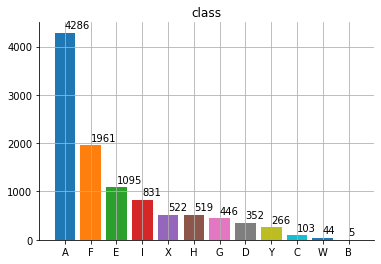

In [512]:
def plot_single_categorical(df, col):
    plt.figure(figsize = (6, 4))
    plt.bar(x = df[col].value_counts().index, height = df[col].value_counts(), color = mcolors.TABLEAU_COLORS)
    sns.despine(top = True)
    n_level = df[col].nunique()
    for x_coor in range(n_level):
        plt.annotate(df[col].value_counts().iloc[x_coor], 
                     xy = (x_coor, 
                           df[col].value_counts().iloc[x_coor] + df[col].value_counts().iloc[0]/50))
    plt.xticks(rotation = 0)
    plt.grid()
    plt.title(col)
    plt.show()
    
plot_single_categorical(avila, 'class')

The graph above shows that the number of samples with target label 'A' is much larger than any other ones in the target. There are more than twice samples with target label 'A' than samples with 'F' whose quantity is only second to samples with 'A'.

In [513]:
tar = pd.get_dummies(avila['class'])
tar = tar.astype(str)

In [514]:
avila = avila.join(tar)
avila.head(2)

,intercolumnar distance,upper margin,lower margin,exploitation,row number,modular ratio,interlinear spacing,weight,peak number,modular ratio/ interlinear spacing,...,C,D,E,F,G,H,I,W,X,Y
0,0.266074,-0.165620,0.320980,0.483299,0.172340,0.273364,0.371178,0.929823,0.251173,0.159345,...,0,0,0,0,0,0,0,0,0,0
1,0.130292,0.870736,-3.210528,0.062493,0.261718,1.436060,1.465940,0.636203,0.282354,0.515587,...,0,0,0,0,0,0,0,0,0,0


In [543]:
def plot_single_categorical(df, col):
    plt.figure(figsize = (6, 4))
    plt.bar(x = df[col].value_counts().index, height = df[col].value_counts(), color = mcolors.TABLEAU_COLORS)
    sns.despine(top = True)
    n_level = df[col].nunique()
    for x_coor in range(n_level):
        plt.annotate(df[col].value_counts().iloc[x_coor], 
                     xy = (x_coor, 
                           df[col].value_counts().iloc[x_coor] + df[col].value_counts().iloc[0]/50))
    plt.xticks(rotation = 0)
    plt.grid()
    plt.title(col)
    print(f"ratio of quantity in label 'A' samples to other samples: {round(df[col].value_counts()[1]/df[col].value_counts()[0], 2)}")
    plt.show()

ratio of quantity in label 'A' samples to other samples: 0.7


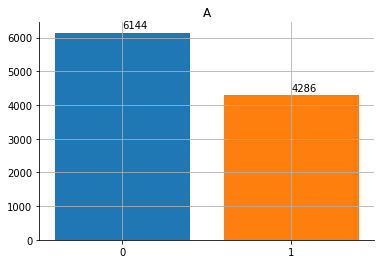

In [544]:
plot_single_categorical(avila, 'A')

The graph above shows that the number of samples with label 'A' is less than half in the whole dataset. 

The ratio of quantity in label 'A' samples to other samples is 7:10.

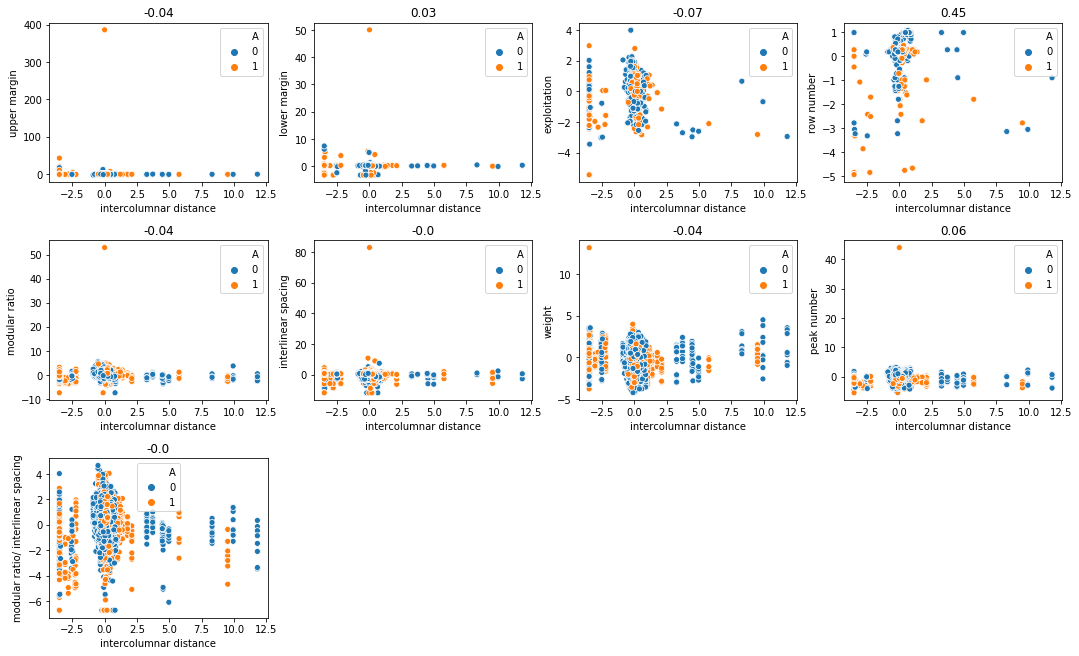

In [516]:
def scatter_fea_corr_classif_targ(df, features, target):
    corr = df[features].corr()
    n_features = len(features)
    n_sub_figs = (n_features * n_features - n_features) / 2
    if n_sub_figs < 4:
        nrows = 1
        ncols = n_sub_figs
        fig = plt.figure(figsize = (ncols * 3.75, 3))
    else:
        nrows =  math.ceil(n_sub_figs / 4)
        ncols = 4
        fig = plt.figure(figsize = (15, nrows * 3))
    
    m = 1
    for col in features:
        col_index = features.index(col)
        i = 1
        while (col_index + i) <= (n_features - 1):
            corr_val = 0
            ax = fig.add_subplot(nrows, ncols, m)
            ax = sns.scatterplot(x = col, y = features[col_index + i], hue = target, data = df)
            corr_val = round(corr.loc[col, features[col_index + i]], 2)
            plt.title(corr_val)
            
            i += 1
            m += 1
        if col_index == 0:
            break
    plt.tight_layout()
    plt.show()
    
scatter_fea_corr_classif_targ(avila, num.tolist(), 'A')

The graphs above shows that outliers exist in this dataset.

In [517]:
def outlier_index(df, features):
    index_outlier = pd.DataFrame().index
    
    for feature in features:
        minimum = np.quantile(df[feature], 0.25) - 1.5 * iqr(df[feature])
        index_outlier = index_outlier.append(df[df[feature] < minimum].index)
        maximum = np.quantile(df[feature], 0.75) + 1.5 * iqr(df[feature])
        index_outlier = index_outlier.append(df[df[feature] > maximum].index)
    
    index_outlier = index_outlier.drop_duplicates(keep = 'first')
    return index_outlier

index_outlier = outlier_index(avila, num)
print(f'There are {len(index_outlier)} outlier samples.')
index_outlier.sort_values()

There are 4406 outlier samples.


Int64Index([    1,     3,     5,     6,    10,    11,    14,    15,    17,
               19,
            ...
            10407, 10408, 10409, 10412, 10416, 10417, 10419, 10422, 10423,
            10429],
           dtype='int64', length=4406)

4406 outlier samples have been itentified from the dataset. These outlier samples are to be kept as removing them which represent 40% of the dataset would cause information loss. 

In [518]:
X = avila[num]
y = avila['A']

In [519]:
mi = pd.Series(mutual_info_classif(X, y, random_state = 42), index = num, name = 'score')
mi = mi.sort_values(ascending = False)
mi

exploitation                          0.671795
lower margin                          0.198060
intercolumnar distance                0.185388
upper margin                          0.163231
row number                            0.087748
peak number                           0.077589
interlinear spacing                   0.061540
modular ratio                         0.042896
modular ratio/ interlinear spacing    0.020846
weight                                0.000000
Name: score, dtype: float64

The feature selection technique shows that 'exploitation' is the most significant feature in predicting target. And the order in which the features are ranked by their significance descendingly is derived.

In [520]:
avila_mean = pd.DataFrame(avila[mi.index].mean(), columns = ['mean'])
avila_std = pd.DataFrame(avila[mi.index].std(), columns = ['std'])
avila_mean.join(avila_std)

,mean,std
exploitation,-0.002387,1.008527
lower margin,-0.000525,1.120202
intercolumnar distance,0.000852,0.991431
upper margin,0.033611,3.920868
row number,0.006370,0.992053
peak number,0.012914,1.087665
interlinear spacing,0.005605,1.313754
modular ratio,0.013973,1.126245
modular ratio/ interlinear spacing,0.000818,1.007094
weight,0.010323,1.003507


The table above shows that there is no big difference between features in the aspect of mean and standard deviation, meaning that range of each feature is similar and 'scale' is not necessary.

In [521]:
X = avila[mi.index]
y = avila['A'].astype(int)

In [522]:
lr = LogisticRegression(random_state = 42)
knn = KNeighborsClassifier()
svc = SVC(random_state = 42)
tree = DecisionTreeClassifier(max_features = 'auto', random_state = 42)

In [523]:
alg_dict = {lr: 'lr', svc: 'svc', knn: 'knn', tree: 'tree'}

In [524]:
def num_feat_perform(algorithm, feat_ordered, X, y, metric):
    scores = []
    for i in range(1, len(feat_ordered)+1):
        pred_data = X.iloc[:, 0:i]
        score = mean(cross_val_score(algorithm, pred_data, y, scoring = metric, cv = 5))
        scores.append(score)

    n_features = len(feat_ordered)
    plt.plot(np.arange(n_features), scores, marker = 'x')
    plt.xticks(np.arange(n_features), np.arange(1, n_features + 1))
    for i in range(n_features):
        plt.text(i, scores[i], s = round(scores[i], 2))
    plt.grid()
    plt.xlabel('no. of features')
    plt.ylabel('score')
    
def num_feat_perform_compare(alg_dict, feat_ordered, X, y, metric):
    n_algorithm = len(alg_dict)
    algorithms = list(alg_dict.keys())
    alg_names = list(alg_dict.values())
    if n_algorithm <= 2:
        nrows = 1
        ncols = n_algorithm
        fig = plt.figure(figsize = (ncols * 6, 4))
    else:
        nrows = math.ceil(n_algorithm / 2)
        ncols = 2
        fig = plt.figure(figsize = (12, nrows * 4))

    for n in range(n_algorithm):
        ax = fig.add_subplot(nrows, ncols, n + 1)
        ax = num_feat_perform(algorithms[n], feat_ordered, X, y, metric)
        plt.title(f"'{alg_names[n]}' performance by '{metric}'")
        
    plt.tight_layout()
    plt.show()

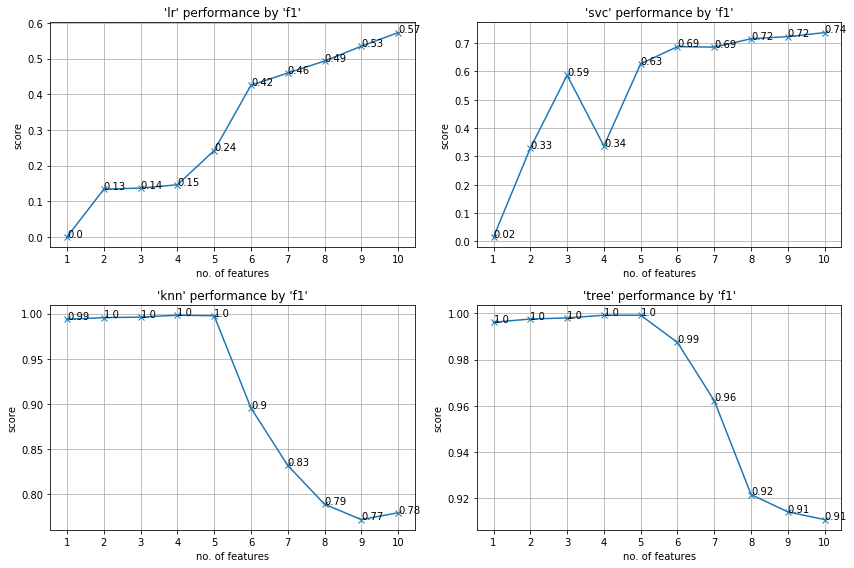

In [525]:
num_feat_perform_compare(alg_dict, mi.index, X, y, 'f1')

The graphs above shows:
1. All of the 10 features have to be involved to achieve the best performance with the use of algorithm 'LogisticRegression' or 'SVC'. The best score has been 0.57 with 'LogisticRegression' and 0.74 with 'SVC';


2. The algorithm 'KNN' or 'Decision Tree' is able to achieve the best performance with a full mark in the use of only first feature.

In [526]:
train_sizes = np.linspace(start = 10, stop = X.shape[0] * 0.8, num = 6, dtype = int)

In [527]:
def plot_learning_curve(train_scores, test_scores):
    train_scores = pd.DataFrame(train_scores, index = train_sizes, columns = ['split1', 'split2', 'split3', 'split4', 'split5'])
    train_scores = train_scores.join(pd.Series(train_scores.mean(axis = 1), name = 'mean'))

    test_scores = pd.DataFrame(test_scores, index = train_sizes, columns = ['split1', 'split2', 'split3', 'split4', 'split5'])
    test_scores = test_scores.join(pd.Series(test_scores.mean(axis = 1), name = 'mean'))

    plt.plot(train_scores['mean'], label = 'train_scores')
    plt.plot(test_scores['mean'], label = 'test_scores')
    plt.legend()
    plt.grid()
    plt.xlabel('no. of training samples')
    
def two_metric_graph(algorithm, X, y):
    fig = plt.figure(figsize = (10, 4))

    for i, metric in enumerate(['f1', 'balanced_accuracy']):
        train_sizes_abs, train_scores, test_scores = learning_curve(algorithm, X, y, train_sizes = train_sizes, 
                                                                    scoring = metric, cv = 5, shuffle = True, 
                                                                    random_state = 42)
        ax = fig.add_subplot(1, 2, i + 1)
        ax = plot_learning_curve(train_scores, test_scores)
        plt.title(f"'performance by '{metric}'")

    plt.tight_layout()
    plt.show()

In [528]:
alg_dict_2 = {knn: 'knn', tree: 'tree'}

'knn' to be implemented:


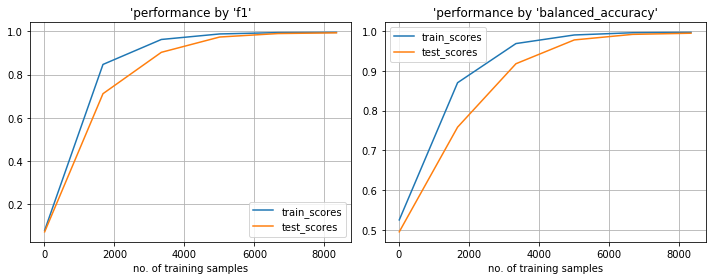

'tree' to be implemented:


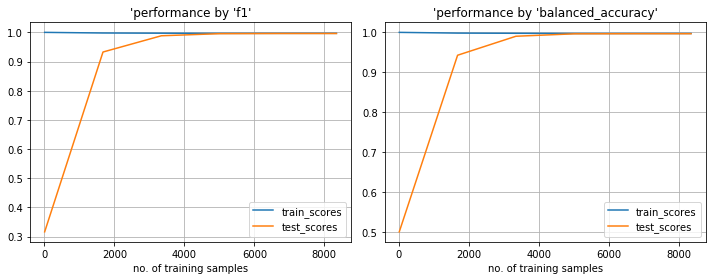

In [529]:
algorithms = list(alg_dict_2.keys())
alg_names = list(alg_dict_2.values())

for i in range(len(alg_dict_2)):
    print(f"'{alg_names[i]}' to be implemented:")
    two_metric_graph(algorithms[i], X[mi.index[0:1]], y)

The graphs above show that 'Decision Tree' presents an apparent overfitting in predicting the target. On the other hand, 
'KNN' shows a reasonable learning curve that validation score goes higher along with increasing number of training samples.

The model constructed with the algorithm 'KNN' and feature 'exploitation' was proved to achieve a full validation mark measured by 'f1', so that model would be selected and stored for future use.

In [530]:
mi.index[0]

'exploitation'

The feature 'exploitation' would be used for constructing model.

In [534]:
knn.fit(X[[mi.index[0]]], y)
joblib.dump(knn, 'knn.joblib')

['knn.joblib']

The model has been constructed and stored in the file 'knn.joblib'.

Conclusion:
1. All of the samples in 'avila_tr.txt' have been trained to get the model;
2. The model has been constructed with the algorithm 'KNeighborsClassifier' and the feature 'exploitation';
3. The model is able to achieve a 100% performance score measured by 'f1' although only one feature is used. 